# CatBOOST模型

## CatBOOST模型原理介绍

**CatBoost（Categorical Boosting）**是一种基于梯度提升决策树（GBDT）的机器学习算法，专为处理分类特征和高效建模而设计。它在结构和性能上与其他GBDT框架（如XGBoost、LightGBM）类似，但在处理分类特征、防止过拟合和训练速度上有显著改进

## CatBOOST模型核心技术

### Ordered Boosting（有序提升）

传统梯度提升决策树在计算目标编码时容易造成**数据泄露**问题（即训练数据中的目标变量可能对特征计算造成不合理影响）。CatBoost使用了一种随机排列的技术：
1. 将数据随机排列。
2. 对于每一行，只使用排列顺序中前面的行计算目标编码值，从而避免了数据泄露问题。

### 对称树（Symmetric Tree）

与XGBoost和LightGBM不同，CatBoost构造的是**对称树**： 
  - 所有决策树的每一层都在所有数据上使用相同的分裂条件。
  - 优势： 
      - **训练速度更快**： 分裂条件只需要计算一次。
      - **预测速度更快**： 在预测时只需按树的对称路径遍历即可。
      - **鲁棒性更高**： 在小数据集上表现更稳定。

### 高效目标编码（Efficient Target Encoding）

对于分类特征，CatBoost将其转换为数值特征时，使用了**Ordered Target Encoding**方法： 
  - 通过分批处理或数据折叠来确保训练数据和目标编码之间相互独立，避免数据泄露。
  - 目标编码支持**分类特征高基数**（如一个特征有上千个不同类别）。

### 内置文本处理

CatBoost内置文本特征预处理方法，如TF-IDF、文本嵌入等，可以直接对文本特征进行建模。，避免了手动设计特征的复杂过程。

# CatBOOST模型优缺点

## CatBOOST模型优点

- **强大的分类特征处理能力**：无需对类别特征手动编码，减少特征工程的复杂性
- **防止数据泄露**：Ordered Boosting和目标编码方法避免了常见的信息泄露问题

## CatBOOST模型缺点

- **对超大数据集的内存需求较高**：与LightGBM相比，内存使用效率稍差
- **训练速度比LightGBM慢**：尽管比XGBoost快，但在纯数值特征数据集上仍不及LightGBM

# CatBoost模型案例（回归）

## CatBoostRegressor

- **iterations**：决策树的数量（迭代次数）
    - 增加iterations会提高模型的表现效果，但是iterations设置过大也会导致过拟合
- **learning_rate**：学习率，控制每棵树的权重
    - learning_rate越小，则每棵树对最终决策的影响越低，模型更稳健，但是同时也需要更多的树来提升性能
- **depth**：树的最大深度，默认6
- **loss_function**：损失函数
    - `Logloss`：二分类
    - `MultiClass`：多分类
    - `RMSE`：均方根误差（Root Mean Square Error），默认损失函数
    - `MAE`：平均绝对误差（Mean Absolute Error）
    - `MAPE`：平均绝对百分比误差（Mean Absolute Percentage Error）
- **random_seed**：随机数种子，确保实验可复现
- **l2_leaf_reg**：L2正则化系数，默认3，防止过拟合。
- **early_stopping_rounds**：早停系数。
- **cat_features**：指定类别特征。
- **embedding_features**：指定嵌入特征。
- **text_features**：指定文本特征列，自动进行NLP处理。
- **border_count**：连续特征分箱时的最大分箱数。

## 波士顿房价数据集

**Boston Housing Dataset（波士顿房价数据集）**是一个回归数据集，该数据集包含506个样本，每个样本有13个特征，该数据集用于根据犯罪率、房屋房间数、空气污染等因素对波士顿地区的房价进行预测。

- MEDV：住房价格中位数（单位：千美元）
- CRIM：该镇的人均犯罪率
- ZN：住宅用地超过 25000 平方英尺的比例（%）
- INDUS：非零售商用土地比例（%）
- CHAS：是否靠近查尔斯河（1=是，0=否）
- NOX：一氧化氮浓度（空气污染指标，单位：ppm）
- RM：每栋住宅的平均房间数
- AGE：1940 年之前建成房屋的比例（%）
- DIS：到波士顿五个中心区域的加权距离
- RAD：距离高速公路的便利指数
- TAX：每 $10,000 资产的房产税率
- PTRATIO：城镇师生比例
- B：黑人比例指标
- LSTAT：低收入人群比例（%）

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 加载波士顿房价数据集
# 该数据集包含506个样本，每个样本有13个特征，用于预测房价
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data  # 特征变量
y = boston.target  # 目标变量（房价）
boston

{'data':         CRIM    ZN  INDUS CHAS    NOX     RM   AGE     DIS RAD    TAX  \
 0    0.00632  18.0   2.31    0  0.538  6.575  65.2  4.0900   1  296.0   
 1    0.02731   0.0   7.07    0  0.469  6.421  78.9  4.9671   2  242.0   
 2    0.02729   0.0   7.07    0  0.469  7.185  61.1  4.9671   2  242.0   
 3    0.03237   0.0   2.18    0  0.458  6.998  45.8  6.0622   3  222.0   
 4    0.06905   0.0   2.18    0  0.458  7.147  54.2  6.0622   3  222.0   
 ..       ...   ...    ...  ...    ...    ...   ...     ...  ..    ...   
 501  0.06263   0.0  11.93    0  0.573  6.593  69.1  2.4786   1  273.0   
 502  0.04527   0.0  11.93    0  0.573  6.120  76.7  2.2875   1  273.0   
 503  0.06076   0.0  11.93    0  0.573  6.976  91.0  2.1675   1  273.0   
 504  0.10959   0.0  11.93    0  0.573  6.794  89.3  2.3889   1  273.0   
 505  0.04741   0.0  11.93    0  0.573  6.030  80.8  2.5050   1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  396.90   9.14  
 2       

## 代码实现

=== 评估指标 (CatBoost) ===
MSE: 7.4704
RMSE: 2.7332
MAE: 1.8207
MAPE: 9.25%
R² Score: 0.8981


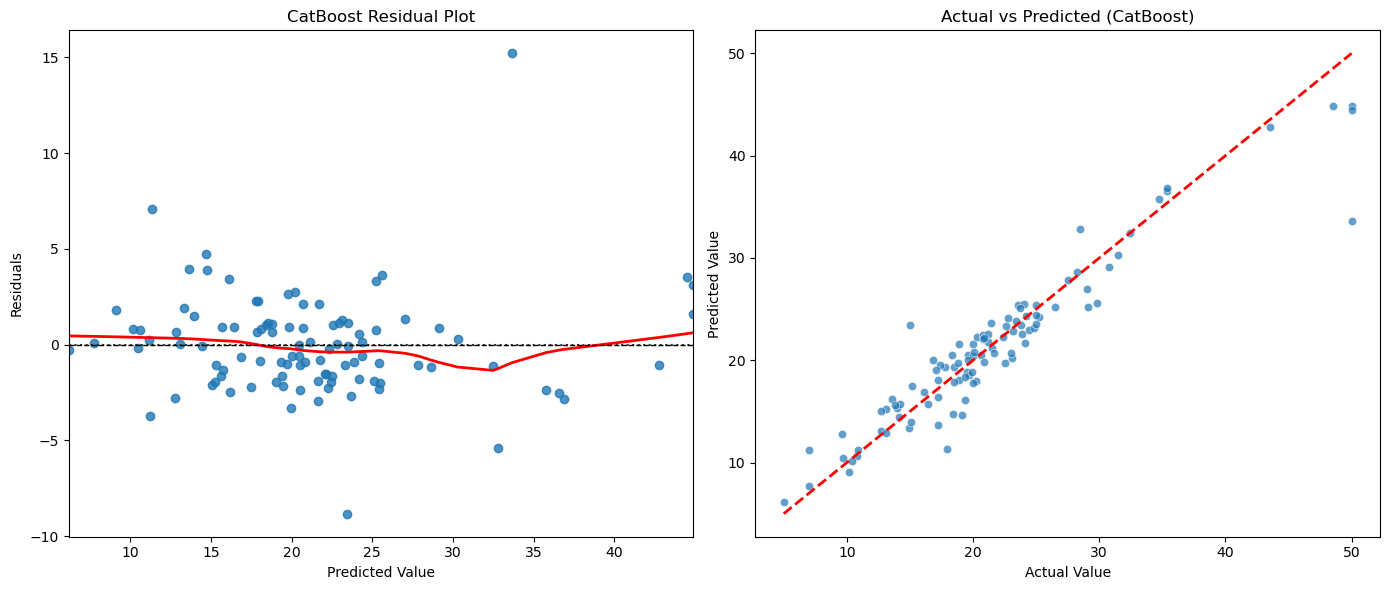

In [2]:
# 导入所需的库
from catboost import CatBoostRegressor, Pool                    # CatBoost 回归器
from sklearn.model_selection import train_test_split      # 划分训练集和测试集
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # 回归评估指标
from sklearn.datasets import fetch_openml                 # 加载新版 Boston 数据集
import pandas as pd                                       # 数据处理
import numpy as np                                        # 数学计算
import seaborn as sns                                     # 可视化
import matplotlib.pyplot as plt                           # 可视化

# 加载 Boston 房价数据集（已被 load_boston 弃用，使用 fetch_openml 方式）
boston = fetch_openml(name='boston', version=1, as_frame=True)

# 提取特征和目标变量
X = boston.data
y = boston.target

# 将类别变量 'CHAS' 转换为 category 类型（CatBoost 需要显式指定类别变量）
X['CHAS'] = X['CHAS'].astype('category')

# 划分训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 自动识别训练集中的类别特征列名
cat_features = X_train.select_dtypes(include='category').columns.tolist()

# 初始化 CatBoost 回归模型，带全参数注释说明
catboost_regressor = CatBoostRegressor(
    iterations=500,               # 决策树数量（迭代次数），较大会提升性能，但可能过拟合
    learning_rate=0.1,            # 学习率，控制每棵树的影响，越小越稳健，但需更多迭代
    depth=6,                      # 决策树的最大深度，控制模型复杂度
    loss_function='RMSE',        # 损失函数：RMSE / MAE / MAPE
    random_seed=42,              # 随机种子，保证结果可复现
    l2_leaf_reg=3,               # L2 正则化系数，控制过拟合，默认值为3
    early_stopping_rounds=50,    # 提前停止训练，如果在指定轮数内无提升
    cat_features=cat_features,   # 指定类别特征列
    embedding_features=None,     # 指定嵌入特征列
    text_features=None,          # 指定文本特征列，自动进行NLP处理
    border_count=254,            # 连续特征分箱时的最大分箱数（默认是254）
    verbose=0                    # 控制训练过程的日志输出（0为静默）
)

# 拟合模型
catboost_regressor.fit(X_train, y_train)

# 预测
y_pred = catboost_regressor.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print("=== 评估指标 (CatBoost) ===")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 残差分析和可视化
residuals = y_test - y_pred
plt.figure(figsize=(14, 6))

# 残差图
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("CatBoost Residual Plot")

# 实际值 vs 预测值图
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (CatBoost)")

plt.tight_layout()
plt.show()

# CatBoost模型可视化

## Pool: 是 CatBoost 中用来封装数据的一个类，用于训练、验证和预测。
- `data`: 输入数据
- `label`: 目标值
- `cat_features`: 指定类别特征
- `text_features`: 指定文本特征
- `embedding_features`: 指定嵌入特征

## cat_clf.plot_tree: CatBoost模型可视化
- `tree_idx`: 要可视化的树的索引（从 0 开始）
- `pool`: 训练数据池。如果模型包含类别型特征（cat_features），必须提供 pool

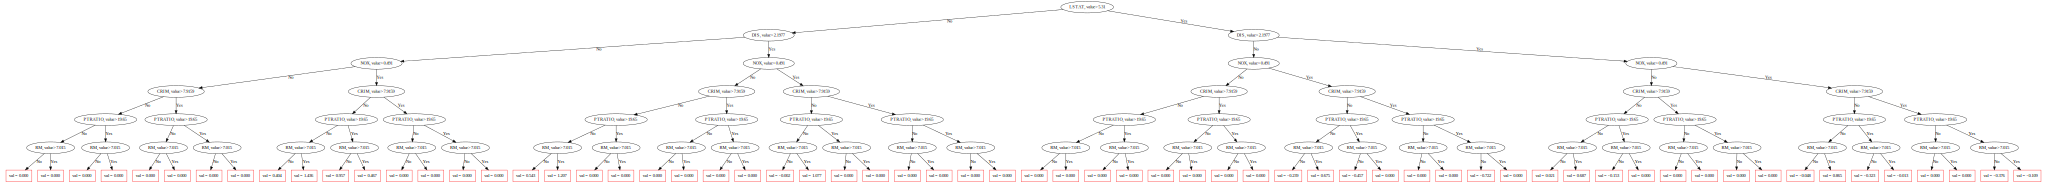

In [3]:
# 创建 CatBoost 专用的 Pool 数据容器对象
# Pool 是 CatBoost 高效处理数据的特殊数据结构，比普通 numpy/pandas 更能优化内存和计算效率
train_pool = Pool(
    data=X_train,          # 训练集特征数据 (DataFrame 或 numpy array)
    label=y_train,         # 对应的目标标签 (Series 或 numpy array)
    cat_features=cat_features  # 指定哪些列是类别型特征（列名列表或列索引列表）
)

# 可视化 CatBoost 模型中的决策树
catboost_regressor.plot_tree(
    tree_idx=3,            # 要可视化的树索引（从0开始）
    pool=train_pool,       # 提供训练数据 Pool（必须包含类别特征信息），这是显示类别特征分割点所必需的
)

# 特征重要度

**特征重要性（feature importance）是 CatBoost 模型中用于衡量各个特征对预测结果贡献程度的指标。**

* 在 CatBoost 中，模型是通过梯度提升方法（Gradient Boosting）加权多个对称决策树组成的。

* 每棵树在训练过程中，会在某些特征上进行分裂，每次分裂都会带来模型损失函数的下降（如目标函数的梯度平方和减少）。

* CatBoost 中每个节点的分裂增益代表了该特征对整体模型性能的贡献。

* 因此，一个特征在多个树的“重要分裂节点”中频繁被使用，其最终特征重要性越高。

* 计算公式为：

$$
\text{Importance}_j = \sum_{m=1}^{M} \sum_{t \in T_m} \Delta \text{Gain}_t \cdot \mathbb{1}(j \in t)
$$

其中：

* \$M\$：CatBoost 中树的数量

* \$T\_m\$：第 \$m\$ 棵树中的所有非叶子分裂节点

* \$\Delta \text{Gain}\_t\$：节点 \$t\$ 分裂带来的目标函数下降量（增益）

* \$\mathbb{1}(j \in t)\$：若节点 \$t\$ 使用特征 \$j\$ 进行分裂，则为 1，否则为 0

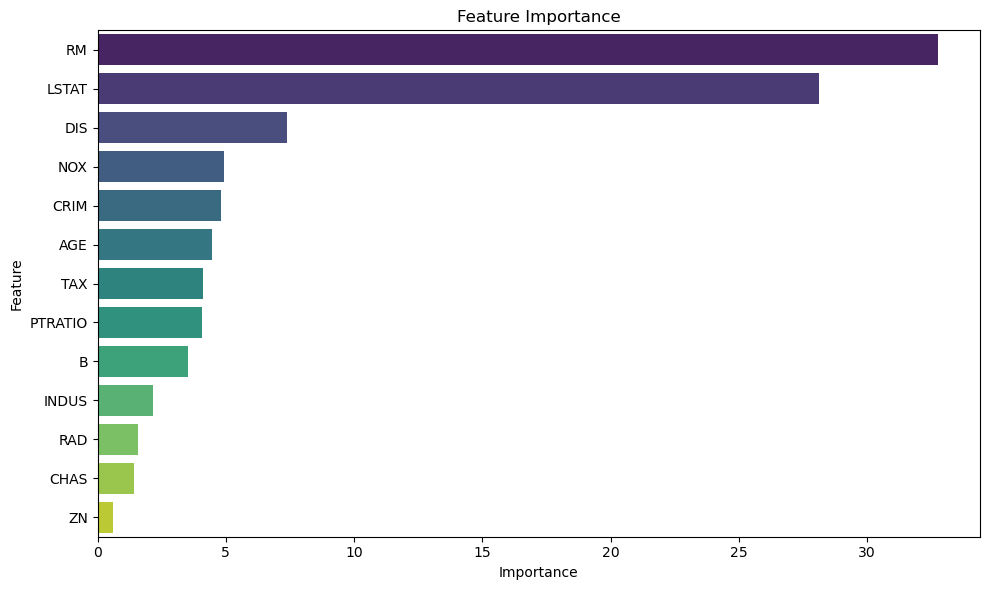

In [3]:
# 特征重要性
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': catboost_regressor.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp, palette='viridis')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()